# Pipeline de Tratamento de Dados de Aviação ✈️

Recentemente, o ônibus que eu costumo pegar para viajar até outra cidade mudou de horário.
O motivo? Atrasos constantes — em média, mais de 30 minutos.

Como viajo bastante, comentei sobre isso com um professor do curso de Engenharia de Software que também costuma ir para a mesma região.
No meio da conversa, surgiu o tema das viagens de avião. Sempre ouvimos que são extremamente precisas… mas será que é assim mesmo?

Meu professor então comentou que a ANAC (Agência Nacional de Aviação Civil) disponibiliza publicamente, no portal do governo (gov.br), os dados de voos realizados no Brasil.
Foi aí que acendeu a ideia: explorar esses dados para descobrir se os aviões realmente são tão pontuais quanto dizem.

## Definindo Métricas e Objetivos

Quando abri os dados da ANAC pela primeira vez, me deparei com um volume gigantesco: mais de 70 mil linhas em cada arquivo mensal.
Para não me perder nesse oceano de informações, decidi começar de forma mais controlada: selecionar apenas três anos consecutivos — 2022, 2023 e 2024.

### O que eu queria descobrir

Com o escopo definido, tracei algumas perguntas que guiariam minha análise:
- Qual aeroporto concentra mais atrasos?
- Os atrasos aumentaram ao longo do tempo?
- Existe um dia da semana mais problemático?
- Em qual período do dia os atrasos são mais frequentes — manhã, tarde ou noite?
- E, claro: qual companhia aérea lidera esse ranking indesejado?

Essas questões funcionaram como minha bússola. Cada métrica seria uma peça para entender melhor o cenário da pontualidade no setor aéreo.

### Regras do jogo

Para que a análise fizesse sentido, precisei estabelecer alguns parâmetros:

1. Considerei apenas voos domésticos — tanto na origem quanto no destino.
2. Classifiquei como atraso qualquer voo cujo horário real de partida fosse posterior ao programado, independente do horário de chegada.
3. Descartei voos de realocação sem passageiros ou cargas (aquelas operações em que o avião voa vazio apenas para reposicionamento). Afinal, o objetivo era medir impacto em viagens reais.

### Fonte dos dados

Todos os dados foram coletados diretamente do [repositório oficial da ANAC](https://www.gov.br/anac/pt-br/acesso-a-informacao/dados-abertos/areas-de-atuacao/voos-e-operacoes-aereas/voo-regular-ativo-vra)

## Como organizei a análise

Antes de mergulhar nas perguntas, precisei organizar os bastidores da análise. Organizei o processo em uma pipeline de dados, em que cada etapa prepara os dados para a análise final.

1. Carregamento dos dados
- 1.1. Loop de leitura por mês
- 1.2. Modelo de definição das colunas relevantes do dataset
2. Limpeza e enriquecimento
- 2.1. Remoção de valores nulos em Status (REALIZADO)
- 2.2. Tratamento de campos de data vazios, nulos ou inexistentes
- 2.3. Inclusão dos valores ICAO de origem/destino e aplicação de filtro
- 2.4. Normalização dos dados de tipo de linha
- 2.5. Remoção dos tipos de autorização que não se encaixam na regra
- 2.6. Filtro final: considerar atraso apenas quando a partida real ocorre depois da partida prevista
3. Exploração guiada pelas métricas
- Nesta fase, cada pergunta definida nos objetivos foi respondida com base exclusivamente nos arquivos limpos gerados pela pipeline.

## 1. Carregamento dos dados

### 1.1 Loop de leitura por mês

Cada arquivo da ANAC representa um mês específico — e como estou analisando três anos (2022, 2023 e 2024), isso significa dezenas de arquivos. Abrir manualmente um por um não faria sentido.

Por isso, criei uma função que percorre automaticamente todos os meses de cada ano e os transforma em DataFrames do Pandas. Para facilitar a manipulação, cada DataFrame ganhou uma chave curta formada pelo mês e ano, como abr23 para abril de 2023.

Além disso, já aproveitei a leitura para:
- Converter colunas de data em datetime, permitindo operações temporais (como calcular diferenças de horários).
- Definir os tipos corretos das variáveis categóricas, garantindo que informações como código ICAO ou número do voo não sejam tratadas como números inteiros.
- Ignorar linhas de cabeçalho desnecessárias, que poderiam atrapalhar a análise.

No final, o loop gera um dicionário de DataFrames (dataFrames), onde cada chave corresponde a um mês e ano específico.

> Exemplo: ao chamar dataFrames["abr23"], tenho em mãos todos os voos de abril de 2023, prontos para serem trabalhados.

In [ ]:
from typing import Dict
import pandas as pd

years = [2022, 2023, 2024]
months = ["janeiro", "fevereiro", "marco", "abril", "maio", "junho", "julho", "agosto", "setembro", "outubro", "novembro", "dezembro"]
dataFrames: Dict[str, pd.DataFrame] = {}

# Definindo loops de leitura dos meses por anos
for year in years:
    for month in months:

        # Definindo nome da chave de cada DataFrame
        var_name = f"{month[:3]}{str(year)[-2:]}"
        
        # Lendo os arquivos CSV
        temp_df = pd.read_csv(
            f"./data/{year}/{month}/vra_{month}_{year}.csv",
            sep=";",
            skiprows=1,
            parse_dates=[
                "Partida Prevista", 
                "Partida Real", 
                "Chegada Prevista", 
                "Chegada Real"
            ],
            dtype={
                "ICAO Empresa Aérea": "string",
                "Número Voo": "string",
                "Código Autorização (DI)": "string",
                "Código Tipo Linha": "string",
                "ICAO Aeródromo Origem": "string",
                "ICAO Aeródromo Destino": "string",
                "Situação Voo": "string",
                "Código Justificativa": "string"
            })
        
        # Adicionando os DataFrames em uma lista
        dataFrames[var_name] = temp_df

# Exibindo o DataFrame de Abril de 2023
display(dataFrames["abr23"].head())

,ICAO Empresa Aérea,Número Voo,Código Autorização (DI),Código Tipo Linha,ICAO Aeródromo Origem,ICAO Aeródromo Destino,Partida Prevista,Partida Real,Chegada Prevista,Chegada Real,Situação Voo,Código Justificativa
0,AMX,0014,0,I,MMMX,SBGR,2023-04-11 20:05:00,2023-04-11 21:05:00,2023-04-12 05:45:00,2023-04-12 06:48:00,REALIZADO,<NA>
1,AMX,0014,0,I,MMMX,SBGR,2023-04-12 20:05:00,2023-04-12 20:14:00,2023-04-13 05:45:00,2023-04-13 05:29:00,REALIZADO,<NA>
2,AMX,0014,0,I,MMMX,SBGR,2023-04-13 20:05:00,2023-04-13 20:05:00,2023-04-14 05:45:00,2023-04-14 05:42:00,REALIZADO,<NA>
3,AMX,0014,0,I,MMMX,SBGR,2023-04-14 20:05:00,2023-04-14 20:16:00,2023-04-15 05:45:00,2023-04-15 05:46:00,REALIZADO,<NA>
4,AMX,0014,0,I,MMMX,SBGR,2023-04-15 20:05:00,2023-04-15 20:04:00,2023-04-16 05:45:00,2023-04-16 05:24:00,REALIZADO,<NA>


### 1.2 Modelo de definição das colunas relevantes do dataset

Depois de estruturar o loop de leitura, o próximo passo foi garantir que todos os arquivos fossem importados da mesma forma. Para evitar dores de cabeça, defini um modelo de importação padronizado.

In [ ]:
# Abrindo o arquivo CSV para edição
dataFrameObject = pd.read_csv(
    "./data_example/data_teste.csv",
    sep=";",
    skiprows=1,
    parse_dates=[
        "Partida Prevista", 
        "Partida Real", 
        "Chegada Prevista", 
        "Chegada Real"
    ],
    dtype={
        "ICAO Empresa Aérea": "string",
        "Número Voo": "string",
        "Código Autorização (DI)": "string",
        "Código Tipo Linha": "string",
        "ICAO Aeródromo Origem": "string",
        "ICAO Aeródromo Destino": "string",
        "Situação Voo": "string",
        "Código Justificativa": "string"
    })

# Exibindo as 5 primeiras linhas do DataFrame
dataFrameObject.head()

# Copiado DataFrame para edição demonstrativa
editableDataFrameObject = dataFrameObject.copy()

## 2. Limpeza e enriquecimento

Depois de carregar os dados crus, chegou a hora de tratar a parte menos glamourosa — mas absolutamente essencial — de qualquer projeto de ciência de dados: a limpeza.

Tudo o que você vai ver daqui em diante foi automatizado em scripts Python, organizados em uma pipeline. A ideia era simples:
1. Pegar os arquivos originais, cheios de inconsistências.
2. Aplicar uma sequência de transformações e filtros.
3. Salvar uma nova versão, limpa e padronizada, pronta para ser usada na análise.

O resultado foi um conjunto paralelo de arquivos, separados por ano e mês, mas agora consistentes e confiáveis. As próximas subseções mostram, passo a passo, como cada parte dessa limpeza foi aplicada.

### 2.1 Remoção de valores nulos em Status (REALIZADO)

Antes de qualquer análise, precisei garantir que estava olhando apenas para voos que de fato aconteceram.
Afinal, os dados da ANAC também incluem registros de voos cancelados, programados ou em outras situações que não interessam ao meu objetivo.

O primeiro filtro, portanto, foi simples: manter apenas as linhas em que o campo “Situação Voo” está marcado como REALIZADO.

In [ ]:
# Número de linhas antes da limpeza
print("Quantidade de Linhas: ",len(editableDataFrameObject))

# Aplicando filtro de situação de Voo
editableDataFrameObject = editableDataFrameObject[editableDataFrameObject["Situação Voo"] == "REALIZADO"]

# Número de linhas após a limpeza
print("Quantidade de Linhas: ",len(editableDataFrameObject))

Quantidade de Linhas:  73701
Quantidade de Linhas:  69550


### 2.2 Tratamento de campos de data vazios, nulos ou inexistentes

Depois de garantir que só os voos realizados entrariam na análise, o próximo cuidado foi verificar se todos eles tinham informações completas de datas.

Por isso, apliquei um filtro que mantém apenas as linhas em que esses quatro campos estavam preenchidos corretamente. Ao remover registros com valores vazios, nulos ou inexistentes, eliminei as inconsistências que poderiam comprometer os resultados.

In [ ]:
# Número de linhas antes da limpeza
print("Quantidade de Linhas: ",len(editableDataFrameObject))

# Aplicando filtro de valores vazios, nulos, inexistêntes em Datas
editableDataFrameObject = editableDataFrameObject[
    #Selecionando colunas de data
    editableDataFrameObject[["Partida Prevista", "Partida Real", "Chegada Prevista", "Chegada Real"]]
    # Verificando se não são nulos
    .notna()
    # Valida linha por linha se são todas true
    .all(axis=1)
    ]

# Número de linhas após a limpeza
print("Quantidade de Linhas: ",len(editableDataFrameObject))

Quantidade de Linhas:  69550
Quantidade de Linhas:  67158


### 2.3 Inclusão dos valores ICAO de origem/destino e aplicação de filtro

Até aqui, já tínhamos apenas voos realizados e com datas completas. Mas ainda restava uma pergunta importante:
quais desses voos eram realmente domésticos?

Os dados originais trazem os códigos ICAO dos aeroportos de origem e destino, mas não dizem diretamente em qual país cada aeroporto está localizado. Para resolver isso, recorri a uma base complementar de códigos ICAO, que contém a correspondência entre o identificador do aeroporto e o país onde ele se encontra.

Com esse mapeamento em mãos, adicionei duas novas colunas ao dataset:

- ISO Aeródromo País Origem
- ISO Aeródromo País Destino

Em seguida, apliquei o filtro final: manter apenas os registros em que tanto a origem quanto o destino estavam no Brasil ("BR").

In [42]:
# Número de linhas antes da primeira limpeza
print("Quantidade de Linhas: ",len(editableDataFrameObject))

# Carregando base de dados de ICAOs
icaoDataFrameObject = pd.read_csv(
    "./data/icao-airport-codes.csv",
    sep=",",
    dtype={
        "ident": "string",
        "type": "category",
        "name": "string",
        "elevation_ft": "Int64",
        "continent": "category",
        "iso_country": "category",
        "iso_region": "string",
        "municipality": "string",
        "icao_code": "string",
        "iata_code": "string",
        "gps_code": "string",
        "local_code": "string",
        "coordinates": "string"
    })
print("ICAO Table:")
display(icaoDataFrameObject.head(10))

# Criando Series de mapeamento ICAO -> País
icaoDataToCountry = icaoDataFrameObject.set_index("ident")["iso_country"]

# Criando os valores da nova coluna ICAO Destino / Origem
iso_pais_origem = editableDataFrameObject["ICAO Aeródromo Origem"].map(icaoDataToCountry)
iso_pais_destino = editableDataFrameObject["ICAO Aeródromo Destino"].map(icaoDataToCountry)

# Adicionado novas colunas ICAO Destino / Origem ao DataFrame
editableDataFrameObject["ISO Aeródromo País Origem"] = iso_pais_origem
editableDataFrameObject["ISO Aeródromo País Destino"] = iso_pais_destino

editableDataFrameObject = editableDataFrameObject[
    (editableDataFrameObject["ISO Aeródromo País Destino"] == "BR") &
    (editableDataFrameObject["ISO Aeródromo País Origem"] == "BR")
]

# Número de linhas após a primeira limpeza
print("Quantidade de Linhas: ",len(editableDataFrameObject))
display(editableDataFrameObject.head(10))

Quantidade de Linhas:  67158
ICAO Table:


,ident,type,name,elevation_ft,continent,iso_country,iso_region,municipality,icao_code,iata_code,gps_code,local_code,coordinates
0,00A,heliport,Total RF Heliport,11,NaN,US,US-PA,Bensalem,<NA>,<NA>,K00A,00A,"40.070985, -74.933689"
1,00AA,small_airport,Aero B Ranch Airport,3435,NaN,US,US-KS,Leoti,<NA>,<NA>,00AA,00AA,"38.704022, -101.473911"
2,00AK,small_airport,Lowell Field,450,NaN,US,US-AK,Anchor Point,<NA>,<NA>,00AK,00AK,"59.947733, -151.692524"
3,00AL,small_airport,Epps Airpark,820,NaN,US,US-AL,Harvest,<NA>,<NA>,00AL,00AL,"34.86479949951172, -86.77030181884766"
4,00AN,small_airport,Katmai Lodge Airport,80,NaN,US,US-AK,King Salmon,<NA>,<NA>,00AN,00AN,"59.093287, -156.456699"
5,00AS,small_airport,Fulton Airport,1100,NaN,US,US-OK,Alex,<NA>,<NA>,00AS,00AS,"34.9428028, -97.8180194"
6,00AZ,small_airport,Cordes Airport,3810,NaN,US,US-AZ,Cordes,<NA>,<NA>,00AZ,00AZ,"34.305599212646484, -112.16500091552734"
7,00CA,small_airport,Goldstone (GTS) Airport,3038,NaN,US,US-CA,Barstow,<NA>,<NA>,00CA,00CA,"35.35474, -116.885329"
8,00CL,small_airport,Williams Ag Airport,87,NaN,US,US-CA,Biggs,<NA>,<NA>,00CL,00CL,"39.427188, -121.763427"
9,00CN,heliport,Kitchen Creek Helibase Heliport,3350,NaN,US,US-CA,Pine Valley,<NA>,<NA>,00CN,00CN,"32.7273736, -116.4597417"


Quantidade de Linhas:  57707


,ICAO Empresa Aérea,Número Voo,Código Autorização (DI),Código Tipo Linha,ICAO Aeródromo Origem,ICAO Aeródromo Destino,Partida Prevista,Partida Real,Chegada Prevista,Chegada Real,Situação Voo,Código Justificativa,ISO Aeródromo País Origem,ISO Aeródromo País Destino
50,TAM,3156,0,N,SBSP,SBSV,2023-02-23 07:40:00,2023-02-23 07:35:00,2023-02-23 10:05:00,2023-02-23 10:00:00,REALIZADO,<NA>,BR,BR
65,TAM,3156,0,N,SBSP,SBSV,2023-02-24 07:40:00,2023-02-24 08:03:00,2023-02-24 10:05:00,2023-02-24 10:22:00,REALIZADO,<NA>,BR,BR
203,TAM,3156,0,N,SBSP,SBSV,2023-02-25 07:55:00,2023-02-25 07:51:00,2023-02-25 10:20:00,2023-02-25 10:09:00,REALIZADO,<NA>,BR,BR
235,AZU,2856,0,N,SBSP,SBRJ,2023-02-04 14:05:00,2023-02-04 13:54:00,2023-02-04 15:05:00,2023-02-04 14:49:00,REALIZADO,<NA>,BR,BR
236,AZU,2856,0,N,SBSP,SBRJ,2023-02-06 18:25:00,2023-02-06 19:40:00,2023-02-06 19:25:00,2023-02-06 20:37:00,REALIZADO,<NA>,BR,BR
238,AZU,2856,0,N,SBSP,SBRJ,2023-02-08 18:25:00,2023-02-08 18:14:00,2023-02-08 19:25:00,2023-02-08 19:16:00,REALIZADO,<NA>,BR,BR
239,AZU,2856,0,N,SBSP,SBRJ,2023-02-09 18:25:00,2023-02-09 19:05:00,2023-02-09 19:25:00,2023-02-09 20:07:00,REALIZADO,<NA>,BR,BR
240,TAM,3157,0,N,SBSV,SBSP,2023-02-10 10:35:00,2023-02-10 10:43:00,2023-02-10 13:10:00,2023-02-10 13:20:00,REALIZADO,<NA>,BR,BR
241,AZU,2856,0,N,SBSP,SBRJ,2023-02-10 18:25:00,2023-02-10 18:32:00,2023-02-10 19:25:00,2023-02-10 19:49:00,REALIZADO,<NA>,BR,BR
243,AZU,2856,0,N,SBSP,SBRJ,2023-02-13 18:25:00,2023-02-13 18:24:00,2023-02-13 19:25:00,2023-02-13 19:28:00,REALIZADO,<NA>,BR,BR


### 2.4 Normalização dos dados de tipo de linha

Entre as colunas fornecidas pela ANAC, existe o Código Tipo de Linha, que indica a natureza do voo. Ele pode assumir quatro valores bem definidos:

- __N__ — Doméstica mista (passageiros ou mista, todos em território brasileiro)
- __C__ — Doméstica cargueira (carga ou mala postal, todos em território brasileiro)
- __I__ — Internacional mista (quando ao menos um aeroporto está fora do Brasil)
- __G__ — Internacional cargueira (quando ao menos um aeroporto está fora do Brasil)

Na prática, porém, nem sempre os registros respeitam esse padrão. Algumas companhias alimentaram o sistema com valores inconsistentes ou simplesmente fora dessa lista.

Para lidar com isso, normalizei os dados:
- Se o valor estava entre os quatro códigos oficiais da ANAC, mantive como estava.
- Caso contrário, substituí por um código genérico: “D”, representando “Desconhecido”.

In [43]:
# Número de linhas antes da primeira normalização
print("Quantidade de Linhas: ",len(editableDataFrameObject))
print("Valores Originais:", editableDataFrameObject["Código Tipo Linha"].unique())

editableDataFrameObject["Código Tipo Linha"] = editableDataFrameObject["Código Tipo Linha"].where(
    editableDataFrameObject["Código Tipo Linha"].isin(["N", "C", "I", "G"]),
    other="D"
)

# Número de linhas depois da normalização
print("Quantidade de Linhas: ",len(editableDataFrameObject))
print("Valores Originais:", editableDataFrameObject["Código Tipo Linha"].unique())

Quantidade de Linhas:  57707
Valores Originais: <StringArray>
['N', 'C', 'G', 'I']
Length: 4, dtype: string
Quantidade de Linhas:  57707
Valores Originais: <StringArray>
['N', 'C', 'G', 'I']
Length: 4, dtype: string


### 2.5 Remoção dos tipos de autorização que não se encaixam na regra

Nem todo voo registrado pela ANAC representa uma operação que impacta passageiros ou cargas. Existem etapas técnicas — como realocação de aeronaves sem transporte de pessoas ou objetos — que não fazem sentido para a análise de atrasos.

Para garantir consistência, filtrei apenas os voos que se enquadram nas categorias de operações reais, segundo os códigos de autorização definidos pela ANAC:
- 0 — Etapa regular
- 2 — Etapa extra
- 3 — Etapa de retorno
- 4 — Inclusão de etapa
- 7 — Etapa de voo de fretamento
- 9 — Etapa de voo charter
- E — Etapa não remunerada com transporte de objetos

Com isso, todos os demais códigos — como voos duplicados (D) ou etapas sem transporte de nada (6) — foram descartados.

In [1]:
# Número de linhas antes da limpeza
print("Quantidade de Linhas: ",len(editableDataFrameObject))
display(editableDataFrameObject.head(10))

# Aplicando filtro de valores válidos para Código Autorização (DI)
editableDataFrameObject = editableDataFrameObject[editableDataFrameObject["Código Autorização (DI)"].isin(["0", "2", "3", "4", "7", "9", "E"])]

# Número de linhas depois da limpeza
print("Quantidade de Linhas: ",len(editableDataFrameObject ))
display(editableDataFrameObject.head(10))

NameError: name 'editableDataFrameObject' is not defined

### 2.6 Filtro final: considerar atraso apenas quando a partida real ocorre depois da partida prevista

Depois de passar por todas as etapas de limpeza e padronização, chegou a hora do filtro mais importante: definir, de fato, o que é atraso.

Pelas regras que estabeleci no início, só faz sentido considerar atrasado o voo cuja partida real ocorreu depois da partida prevista. Não importa se a chegada foi adiantada ou se a companhia conseguiu recuperar tempo no ar — o atraso é medido na decolagem.

Aplicando esse critério, o dataset final passou a conter apenas voos domésticos, realizados, completos e relevantes, mas agora filtrados para mostrar somente aqueles em que o relógio do embarque realmente estourou.

In [ ]:
# Número de linhas antes da limpeza
print("Quantidade de Linhas: ",len(editableDataFrameObject))
display(editableDataFrameObject.head(10))

# Aplicando filtro de Voos Atrasados
editableDataFrameObject = editableDataFrameObject[editableDataFrameObject["Partida Prevista"] < editableDataFrameObject["Partida Real"]]

# Número de linhas antes da limpeza
print("Quantidade de Linhas: ",len(editableDataFrameObject ))
display(editableDataFrameObject.head(10))

Quantidade de Linhas:  57707


,ICAO Empresa Aérea,Número Voo,Código Autorização (DI),Código Tipo Linha,ICAO Aeródromo Origem,ICAO Aeródromo Destino,Partida Prevista,Partida Real,Chegada Prevista,Chegada Real,Situação Voo,Código Justificativa,ISO Aeródromo País Origem,ISO Aeródromo País Destino
50,TAM,3156,0,N,SBSP,SBSV,2023-02-23 07:40:00,2023-02-23 07:35:00,2023-02-23 10:05:00,2023-02-23 10:00:00,REALIZADO,<NA>,BR,BR
65,TAM,3156,0,N,SBSP,SBSV,2023-02-24 07:40:00,2023-02-24 08:03:00,2023-02-24 10:05:00,2023-02-24 10:22:00,REALIZADO,<NA>,BR,BR
203,TAM,3156,0,N,SBSP,SBSV,2023-02-25 07:55:00,2023-02-25 07:51:00,2023-02-25 10:20:00,2023-02-25 10:09:00,REALIZADO,<NA>,BR,BR
235,AZU,2856,0,N,SBSP,SBRJ,2023-02-04 14:05:00,2023-02-04 13:54:00,2023-02-04 15:05:00,2023-02-04 14:49:00,REALIZADO,<NA>,BR,BR
236,AZU,2856,0,N,SBSP,SBRJ,2023-02-06 18:25:00,2023-02-06 19:40:00,2023-02-06 19:25:00,2023-02-06 20:37:00,REALIZADO,<NA>,BR,BR
238,AZU,2856,0,N,SBSP,SBRJ,2023-02-08 18:25:00,2023-02-08 18:14:00,2023-02-08 19:25:00,2023-02-08 19:16:00,REALIZADO,<NA>,BR,BR
239,AZU,2856,0,N,SBSP,SBRJ,2023-02-09 18:25:00,2023-02-09 19:05:00,2023-02-09 19:25:00,2023-02-09 20:07:00,REALIZADO,<NA>,BR,BR
240,TAM,3157,0,N,SBSV,SBSP,2023-02-10 10:35:00,2023-02-10 10:43:00,2023-02-10 13:10:00,2023-02-10 13:20:00,REALIZADO,<NA>,BR,BR
241,AZU,2856,0,N,SBSP,SBRJ,2023-02-10 18:25:00,2023-02-10 18:32:00,2023-02-10 19:25:00,2023-02-10 19:49:00,REALIZADO,<NA>,BR,BR
243,AZU,2856,0,N,SBSP,SBRJ,2023-02-13 18:25:00,2023-02-13 18:24:00,2023-02-13 19:25:00,2023-02-13 19:28:00,REALIZADO,<NA>,BR,BR


Quantidade de Linhas:  23612


,ICAO Empresa Aérea,Número Voo,Código Autorização (DI),Código Tipo Linha,ICAO Aeródromo Origem,ICAO Aeródromo Destino,Partida Prevista,Partida Real,Chegada Prevista,Chegada Real,Situação Voo,Código Justificativa,ISO Aeródromo País Origem,ISO Aeródromo País Destino
65,TAM,3156,0,N,SBSP,SBSV,2023-02-24 07:40:00,2023-02-24 08:03:00,2023-02-24 10:05:00,2023-02-24 10:22:00,REALIZADO,<NA>,BR,BR
236,AZU,2856,0,N,SBSP,SBRJ,2023-02-06 18:25:00,2023-02-06 19:40:00,2023-02-06 19:25:00,2023-02-06 20:37:00,REALIZADO,<NA>,BR,BR
239,AZU,2856,0,N,SBSP,SBRJ,2023-02-09 18:25:00,2023-02-09 19:05:00,2023-02-09 19:25:00,2023-02-09 20:07:00,REALIZADO,<NA>,BR,BR
240,TAM,3157,0,N,SBSV,SBSP,2023-02-10 10:35:00,2023-02-10 10:43:00,2023-02-10 13:10:00,2023-02-10 13:20:00,REALIZADO,<NA>,BR,BR
241,AZU,2856,0,N,SBSP,SBRJ,2023-02-10 18:25:00,2023-02-10 18:32:00,2023-02-10 19:25:00,2023-02-10 19:49:00,REALIZADO,<NA>,BR,BR
246,AZU,2856,0,N,SBSP,SBRJ,2023-02-16 18:25:00,2023-02-16 18:44:00,2023-02-16 19:25:00,2023-02-16 19:37:00,REALIZADO,<NA>,BR,BR
247,AZU,2856,0,N,SBSP,SBRJ,2023-02-17 18:25:00,2023-02-17 18:40:00,2023-02-17 19:25:00,2023-02-17 19:42:00,REALIZADO,<NA>,BR,BR
248,AZU,2856,0,N,SBSP,SBRJ,2023-02-18 14:05:00,2023-02-18 16:03:00,2023-02-18 15:05:00,2023-02-18 16:57:00,REALIZADO,<NA>,BR,BR
255,AZU,2856,0,N,SBSP,SBRJ,2023-02-28 18:25:00,2023-02-28 18:53:00,2023-02-28 19:25:00,2023-02-28 19:48:00,REALIZADO,<NA>,BR,BR
257,AZU,2857,0,N,SBCF,SBCT,2023-02-02 08:00:00,2023-02-02 08:02:00,2023-02-02 09:40:00,2023-02-02 09:44:00,REALIZADO,<NA>,BR,BR


### 2.7 Execução automatizada da pipeline sobre todos os arquivos, gerando datasets limpos organizados em pastas por ano e mês

Embora eu tenha detalhado cada etapa de tratamento de forma isolada para fins de explicação, na prática o processo foi encapsulado em uma pipeline automatizada. Garantindo reprodutibilidade, escalabilidade e consistência na preparação dos dados, eliminando a necessidade de executar os filtros manualmente para cada arquivo.

A pipeline foi estruturada em Python, distribuída em dois módulos principais:

- `pipeline.py`
- `steps/data_cleaning.py`

Com isso, cada arquivo bruto (`data/`) é processado automaticamente e armazenado em uma versão limpa (`data_cleaned/`), pronta para ser usada na análise.

A organização dos diretórios do projeto seguiu o padrão abaixo:
```bash
Medium/
├── pipeline.py
├── steps/
│   └── data_cleaning.py
├── data/                     # Arquivos crus da ANAC
│   ├── 2022/
│   │   ├── janeiro/
│   │   │   └── vra_janeiro_2022.csv
│   │   ├── fevereiro/
│   │   │   └── vra_fevereiro_2022.csv
│   │   └── ...
│   ├── 2023/
│   │   └── ...
│   └── 2024/
│       └── ...
└── data_cleaned/             # Arquivos tratados pela pipeline
    ├── 2022/
    │   ├── jan/
    │   │   └── jan22.csv
    │   ├── fev/
    │   │   └── fev22.csv
    │   └── ...
    ├── 2023/
    │   └── ...
    └── 2024/
        └── ...
```

> Para rodar a pipeline novamente basta executar, dentro da pasta Medium/:
> ```bash
> python pipeline.py
>```

## 3. Exploração guiada pelas métricas

Com os dados limpos e enriquecidos partimos para a definição das respostas que procuramos

In [4]:
# Criando DataFrame de dados limpos
from typing import Dict
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

years = [2022, 2023, 2024]
months = ['jan', 'fev', 'mar', 'abr', 'mai', 'jun', 'jul', 'ago', 'set', 'out', 'nov', 'dez']
cleanDataFrames: Dict[str, pd.DataFrame] = {}

for year in years:
    for month in months:
        var_name = f"{month}{str(year)[-2:]}"
        # Criando Dict de dados limpos
        cleanDataFrames[var_name] = pd.read_csv(f"./data_cleaned/{year}/{month}/{var_name}.csv", sep=";")

### 3.6 Compania com mais atrasos



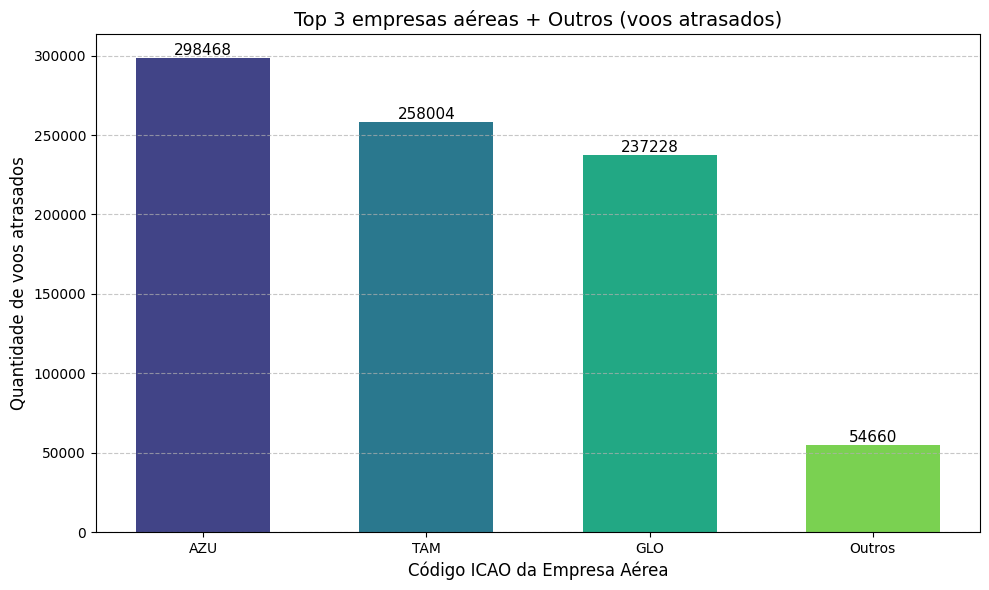

In [9]:
# Contagem por mês
monthly_counts = {}
for key, df in cleanDataFrames.items():
    counts = df['ICAO Empresa Aérea'].value_counts()
    monthly_counts[key] = counts

# Soma acumulada por empresa em todos os meses
total_counts = defaultdict(int)
for counts in monthly_counts.values():
    for company, qty in counts.items():
        total_counts[company] += qty

# Transformar dict em DataFrame
total_df = pd.DataFrame.from_dict(total_counts, orient='index', columns=['Total'])
total_df = total_df.sort_values('Total', ascending=False)

# Selecionar top 3 e criar "Outros"
top3 = total_df.head(3)
others_sum = total_df.iloc[3:].sum().values[0]

plot_df = top3.copy()
plot_df.loc['Outros'] = others_sum

# Plot
plt.figure(figsize=(10,6))
bars = plt.bar(plot_df.index, plot_df['Total'], color=sns.color_palette('viridis', 4), width=0.6)

# Adicionando valores no topo das barras
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 5, f'{int(height)}', ha='center', va='bottom', fontsize=11)

plt.title("Top 3 empresas aéreas + Outros (voos atrasados)", fontsize=14)
plt.ylabel("Quantidade de voos atrasados", fontsize=12)
plt.xlabel("Código ICAO da Empresa Aérea", fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### 3.1 Aeroporto com Mais Atrasos

In [ ]:
years = [2022, 2023, 2024]
months = ['jan', 'fev', 'mar', 'abr', 'mai', 'jun', 'jul', 'ago', 'set', 'out', 'nov', 'dez']
cleanDataFrames: Dict[str, pd.DataFrame] = {}

for year in years:
    for month in months:
        var_name = f"{month}{str(year)[-2:]}"
        # Exemplo de leitura (substitua pelo seu método de obtenção dos DataFrames)
        cleanDataFrames[var_name] = pd.read_csv(f"../Medium/data_cleaned/{year}/{month}/{var_name}.csv", sep=";")

# Contagem por mês
monthly_counts = {}
for key, df in cleanDataFrames.items():
    counts = df['ICAO Aeródromo Origem'].value_counts()
    monthly_counts[key] = counts

# Soma acumulada por empresa em todos os meses
total_counts = defaultdict(int)
for counts in monthly_counts.values():
    for company, qty in counts.items():
        total_counts[company] += qty

# Transformar dict em DataFrame
total_df = pd.DataFrame.from_dict(total_counts, orient='index', columns=['Total'])
total_df = total_df.sort_values('Total', ascending=False)

# Selecionar top N e criar "Outros"
n = 15
topN = total_df.head(n)
others_sum = total_df.iloc[n:].sum().values[0]

plot_df = topN.copy()
plot_df.loc['Outros'] = others_sum

# Plot
plt.figure(figsize=(14,8))
bars = plt.bar(plot_df.index, plot_df['Total'], color=sns.color_palette('viridis', n+1), width=0.6)

# Adicionando valores no topo das barras
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 5, f'{int(height)}', ha='center', va='bottom', fontsize=11)

plt.title(f"Top {n} Aeroportos + Outros (voos atrasados)", fontsize=14)
plt.ylabel("Quantidade de voos atrasados", fontsize=12)
plt.xlabel("Código ICAO do Aeroporto", fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### 3.2 Qual o aeroporto aumentou o número de atrasos e qual diminuiu o número de atrasos?